# Classification using Naive Bayes

In this activity we will introduce the MultinomialNB classifier available in the naive_bayes module of sklearn. 
We'll start by fitting it using default parameters and then try to improve its performance by doing hyperparameter tuning and explore its performance using a confusion matrix.

Naive Bayes is a statistical classification technique based on Bayes Theorem. It is one of the simplest supervised learning algorithms. Naive Bayes classifier is a fast, accurate and reliable algorithm. Naive Bayes classifiers have high accuracy and speed on large datasets.

References:
- https://towardsdatascience.com/why-how-to-use-the-naive-bayes-algorithms-in-a-regulated-industry-with-sklearn-python-code-dbd8304ab2cf
- https://www.datacamp.com/community/tutorials/naive-bayes-scikit-learn
- https://medium.com/@awantikdas/a-comprehensive-naive-bayes-tutorial-using-scikit-learn-f6b71ae84431


### Dataset Prep

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Read dataset
crime_df = pd.read_csv('./pb_compas.csv')
#crime_df.head()

In [3]:
# clean up
# drop duplicate rows
crime_df.drop_duplicates(inplace=True)
#select columns of interest 
crime_df = crime_df[['age', 'c_charge_degree', 'race', 'sex', 'priors_count','score_text']]
print(crime_df.head())
crime_df.dropna(inplace=True)
crime_df.reset_index(drop=True, inplace=True)
print(crime_df.shape)

   age c_charge_degree              race   sex  priors_count score_text
0   69            (F3)             Other  Male             0        Low
1   69            (F3)             Other  Male             0        Low
2   31             NaN         Caucasian  Male             0     Medium
3   34            (F3)  African-American  Male             0        Low
4   24            (F3)  African-American  Male             4        Low
(14711, 6)


In [4]:
# create dummy fields before split
# converting categorical features using one-hot encoding (i.e., dummy features)
# textbook approach using statsmodels categorical function is depricated
# we will be using pandas get_dummies function instead
crime_df = pd.get_dummies(crime_df, columns=['race','sex','c_charge_degree' ], prefix = ['dummy_race','dummy_sex','dummy_charge_degree'])

In [5]:
# create training and testing sets at 80/20
from sklearn.model_selection import train_test_split
crime_train, crime_test = train_test_split(crime_df, test_size = .2)

In [6]:
print(crime_train.columns)

Index(['age', 'priors_count', 'score_text', 'dummy_race_African-American',
       'dummy_race_Asian', 'dummy_race_Caucasian', 'dummy_race_Hispanic',
       'dummy_race_Native American', 'dummy_race_Other', 'dummy_sex_Female',
       'dummy_sex_Male', 'dummy_charge_degree_(CO3)',
       'dummy_charge_degree_(CT)', 'dummy_charge_degree_(F1)',
       'dummy_charge_degree_(F2)', 'dummy_charge_degree_(F3)',
       'dummy_charge_degree_(F5)', 'dummy_charge_degree_(F6)',
       'dummy_charge_degree_(F7)', 'dummy_charge_degree_(M1)',
       'dummy_charge_degree_(M2)', 'dummy_charge_degree_(MO3)',
       'dummy_charge_degree_(NI0)', 'dummy_charge_degree_(TCX)',
       'dummy_charge_degree_(X)'],
      dtype='object')


In [7]:
# for learning our model we want to use age, c_charge_degree, race, sex, priors_count
# notice that we are only including one of the sex dummy attributes since this was a binary feature
x = crime_train[['age', 'priors_count','dummy_race_African-American',
       'dummy_race_Asian', 'dummy_race_Caucasian', 'dummy_race_Hispanic',
       'dummy_race_Native American', 'dummy_race_Other', 'dummy_sex_Female',
       'dummy_charge_degree_(CO3)', 'dummy_charge_degree_(CT)', 'dummy_charge_degree_(F1)', 'dummy_charge_degree_(F2)', 'dummy_charge_degree_(F3)',
       'dummy_charge_degree_(F5)', 'dummy_charge_degree_(F6)', 'dummy_charge_degree_(F7)', 'dummy_charge_degree_(M1)', 'dummy_charge_degree_(M2)',
       'dummy_charge_degree_(MO3)', 'dummy_charge_degree_(NI0)', 'dummy_charge_degree_(TCX)', 'dummy_charge_degree_(X)']]

x_test = crime_test[['age', 'priors_count','dummy_race_African-American','dummy_race_Asian', 
                     'dummy_race_Caucasian', 'dummy_race_Hispanic','dummy_race_Native American', 
                     'dummy_race_Other', 'dummy_sex_Female',
                     'dummy_charge_degree_(CO3)', 'dummy_charge_degree_(CT)', 'dummy_charge_degree_(F1)', 'dummy_charge_degree_(F2)', 'dummy_charge_degree_(F3)',
                     'dummy_charge_degree_(F5)', 'dummy_charge_degree_(F6)', 'dummy_charge_degree_(F7)', 'dummy_charge_degree_(M1)', 'dummy_charge_degree_(M2)',
                     'dummy_charge_degree_(MO3)', 'dummy_charge_degree_(NI0)', 'dummy_charge_degree_(TCX)', 'dummy_charge_degree_(X)']]

In [8]:
# we want to predict the score text let's make that our y
y = crime_train['score_text']
y_test = crime_test['score_text']

### Modeling

Now that our data is prepared we can start training and evaluating our NB classifier.

Refer to the [The multinomial Naive Bayes classifier](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) for details on the different parameters that can be used with this classifier.


In [9]:
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB() # default params - MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
nb_model.fit(x, y)

MultinomialNB()

In [10]:
print(nb_model.score(x,y))

0.5892250169952413


In [11]:
print(nb_model.score(x_test,y_test))

0.601427115188583


In [12]:
# contingency table of the actual and predicted score text

In [13]:
y_predicted = nb_model.predict(x_test)
ypred = pd.crosstab(y_test, y_predicted, rownames = ['Actual'], colnames = ['Predicted'])
ypred['Total'] = ypred.sum(axis=1) 
ypred.loc['Total'] = ypred.sum()
ypred

Predicted,High,Low,Medium,Total
Actual,,,,
High,314,208,132,654
Low,65,1266,158,1489
Medium,204,406,190,800
Total,583,1880,480,2943


Let's create a function that we can call to plot a confusion matrix

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(Y_test, Y_preds):
    conf_mat = confusion_matrix(Y_test, Y_preds)
    #print(conf_mat)
    fig = plt.figure(figsize=(6,6))
    plt.matshow(conf_mat, cmap=plt.cm.Blues, fignum=1)
    plt.yticks(range(3), range(3))
    plt.xticks(range(3), range(3))
    plt.colorbar();
    for i in range(3):
        for j in range(3):
            plt.text(i-0.2,j+0.1, str(conf_mat[j, i]), color='tab:red')


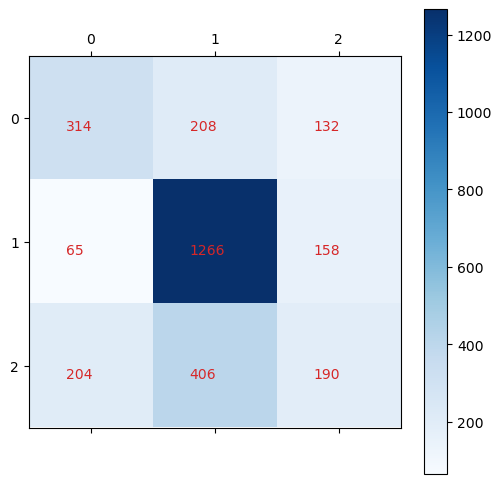

In [15]:

plot_confusion_matrix(y_test, nb_model.predict(x_test))


### Model Tuning using Grid Search On Various Hyperparameters


**GridSearchCV** - Is a wrapper class provided by sklearn which loops through all parameters provided as params_grid parameter with a number of cross-validation folds provided as cv parameter, evaluates model performance on all combinations and stores all results in cv_results_ attribute. It also stores the model which performs best in all cross-validation folds in best_estimator_ attribute and best score in best_score_ attribute.

In [16]:
from sklearn.model_selection import GridSearchCV

params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]}

multinomial_nb_grid = GridSearchCV(MultinomialNB(), param_grid=params, n_jobs=-1, cv=10, verbose=5)
multinomial_nb_grid.fit(x,y)

print('Train Accuracy : %.3f'%multinomial_nb_grid.best_estimator_.score(x, y))
print('Test Accuracy : %.3f'%multinomial_nb_grid.best_estimator_.score(x_test, y_test))
print('Best Accuracy Through Grid Search : %.3f'%multinomial_nb_grid.best_score_)
print('Best Parameters : ',multinomial_nb_grid.best_params_)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Train Accuracy : 0.589
Test Accuracy : 0.602
Best Accuracy Through Grid Search : 0.588
Best Parameters :  {'alpha': 0.01}


Now let's plot the confusion matrix again with the best estimator that we found out using grid search.


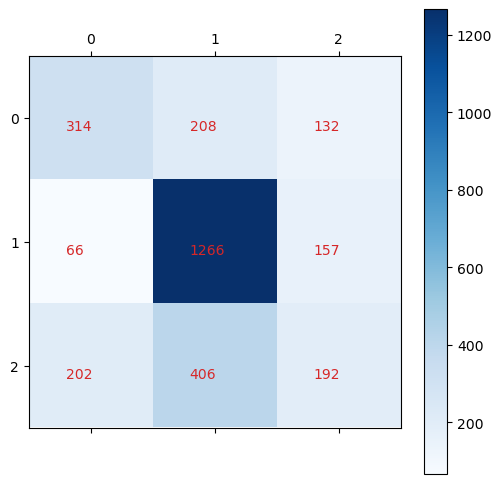

In [17]:
plot_confusion_matrix(y_test, multinomial_nb_grid.best_estimator_.predict(x_test))

In this case we didn't see any noticeable gains for tuning this parameter. This might be different if other features were used for training the model.

## TO DO - Compare the results from using Naive Bayes classifier using cross-validation to the results using Decision Trees.

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [19]:
# Initialize Decision Tree classifier
dt_model = DecisionTreeClassifier(random_state=42)

In [20]:
# Train the model
dt_model.fit(x, y)

DecisionTreeClassifier(random_state=42)

In [21]:
# Calculate accuracy for training and test sets
train_accuracy_dt = dt_model.score(x, y)
test_accuracy_dt = dt_model.score(x_test, y_test)

In [22]:
print("Decision Tree - Train Accuracy: {:.3f}".format(train_accuracy_dt))
print("Decision Tree - Test Accuracy: {:.3f}".format(test_accuracy_dt))

Decision Tree - Train Accuracy: 0.813
Decision Tree - Test Accuracy: 0.673


In [23]:
# Perform cross-validation for Decision Tree
dt_cv_scores = cross_val_score(dt_model, x, y, cv=10)
print("Decision Tree - Cross-Validation Accuracy: {:.3f}".format(np.mean(dt_cv_scores)))

Decision Tree - Cross-Validation Accuracy: 0.673


In [24]:
# Perform cross-validation for Naive Bayes model
nb_cv_scores = cross_val_score(multinomial_nb_grid.best_estimator_, x, y, cv=10)
print("Naive Bayes - Cross-Validation Accuracy: {:.3f}".format(np.mean(nb_cv_scores)))

Naive Bayes - Cross-Validation Accuracy: 0.588


In [25]:
# Comparison Summary
print("\nComparison Summary:")
print(f"Naive Bayes Train Accuracy: {multinomial_nb_grid.best_estimator_.score(x, y):.3f}")
print(f"Naive Bayes Test Accuracy: {multinomial_nb_grid.best_estimator_.score(x_test, y_test):.3f}")
print(f"Naive Bayes Cross-Validation Accuracy: {np.mean(nb_cv_scores):.3f}")

print(f"Decision Tree Train Accuracy: {train_accuracy_dt:.3f}")
print(f"Decision Tree Test Accuracy: {test_accuracy_dt:.3f}")
print(f"Decision Tree Cross-Validation Accuracy: {np.mean(dt_cv_scores):.3f}")


Comparison Summary:
Naive Bayes Train Accuracy: 0.589
Naive Bayes Test Accuracy: 0.602
Naive Bayes Cross-Validation Accuracy: 0.588
Decision Tree Train Accuracy: 0.813
Decision Tree Test Accuracy: 0.673
Decision Tree Cross-Validation Accuracy: 0.673
